# Schelling's  Model of Segregation

Adapted from Frank McCown and Stanford's Nifty Assignments repository.

### Overview
Racial and economic segregation is a pernicious social problem in the United States. Although effort has been extended to desegregate our schools and neighborhoods, the [US continues to remain segregated](https://tcf.org/content/commentary/racial-segregation-is-still-a-problem/) along race and economic lines. 

In this project, I will implement an agent-based model proposed by the American economist and Nobel laureate [Thomas Schelling](https://en.wikipedia.org/wiki/Thomas_Schelling). His model demonstrates that even when we ignore the very real systemic causes at play, small biases at the individual level will still very quickly lead to broad segregation on the larger scale.


### How the Model Works

Schelling's model will now be explained with some minor simplifications. Suppose there are two types of agents: X and O. (On the website linked to above, the agent types were the shapes, triangles and squares.) A population consisting of the two agent types is initially placed into random locations in a neighborhood represented by a grid. After placing all the agents in the grid, each cell is either occupied by an agent or is empty as shown below. 

![alt text](http://www.cs.columbia.edu/~cannon/images/grid1.png "Agents placed randomly")

Now we must determine if each agent is satisfied with its current location. A satisfied agent is one that is surrounded by at least a fraction *t* of agents that are like itself. This threshold *t* is one that will apply to all agents in the model, even though in reality everyone might have a different threshold they are satisfied with. Note that the higher the threshold, the higher the likelihood the agents will not be satisfied with their current location.

For example, if *t = .3*, agent X is satisfied if at least 30% of its neighbors are also X. If fewer than 30% are X, then the agent is not satisfied, and it will want to change its location in the grid. For the remainder of this explanation, let's assume a threshold *t* of .3. This means every agent is fine with being in the minority as long as there are at least 30% of similar agents in adjacent cells.

The picture below shows a satisfied agent because 50% of X's neighbors are also X (.5 > t). 

![alt text](http://www.cs.columbia.edu/~cannon/images/grid2.png "Satisfied agent") 

In the picture below, agent X is not satisfied because only 25% of its neighbors are X (.25 < t). Notice that in this example empty cells are not counted when calculating similarity.

![alt text](http://www.cs.columbia.edu/~cannon/images/grid3.png "Dissatisfied agent")

When an agent is not satisfied, it can be moved to any vacant location in the grid. Any algorithm can be used to choose this new location. For example, a randomly selected cell may be chosen, or the agent could move to the nearest available location. 

In the image below, all dissatisfied agents have an asterisk next to them. We will move each one of these agents and when we're done we will call that the end of a round. 


![alt text](http://www.cs.columbia.edu/~cannon/images/grid4.png "Dissatisfied agents with asterisk") 

The next image shows the new configuration after all the dissatisfied agents have been moved to unoccupied cells at random. Note that the new configuration may cause some agents which were previously satisfied to become dissatisfied! We are now at the beginning of a new round.

![alt text](http://www.cs.columbia.edu/~cannon/images/grid5.png "New configuration") 

All dissatisfied agents in a new grid configuration must be moved in the same round. After the round is complete, a new round begins, and dissatisfied agents are once again moved to new locations in the grid. These rounds continue until all agents in the neighborhood are satisfied with their locations.

Consider the following parameters for the Schelling model:

* grid size: tuple of integers (n,m)
* fraction of population 1: float between 0 and 1.
* fraction of vacant sites in the grid: float between 0 and 1.
* threshold: float between 0 and 1

`start(grid_size,pop,vacancy)` that creates and returns a 2-D numpy array of the appropriate size consisting of integers where each element of the array is assigned as follows:
* part of first agent population:  1
* part of second agent population: -1
* vacant: 0


In [15]:
import random
import numpy as np
import math

In [16]:
def start(grid_size,pop,vacancy):
    arr_size = math.prod(grid_size)
    first_pop = int(pop * arr_size)
    vacancy = int(vacancy * arr_size)
    second_pop = arr_size - first_pop - vacancy
    arr = np.array([0] * vacancy + [1] * first_pop + [-1] * second_pop)
    arr = np.random.permutation(arr)
    arr = arr.reshape(grid_size)

    return arr

In [17]:
def find_neighbors(arr, x, y):
    # returns all horizontal, vertical, diagonal neighbors of (x,y)
    # does not count vacant cells
    rows, cols = arr.shape
    neighbors = []
    for i in [x-1, x, x+1]:
        if i > -1 and i < rows:  # check if row is in bound
            for j in [y-1, y, y+1]:
                if j > -1 and j < cols:  # check if column is in bound
                    if not (i == x and j == y):  # check if not (x,y), the cell itself
                        if not arr[i][j] == 0:  # do not count vacant cells
                            neighbors.append((i, j))
    return neighbors

In [18]:
def find_same_neighbors(arr, neighbors, x, y):
    # returns same neighbors of (x, y)
    same_neighbors = [(i, j) for (i, j) in neighbors if arr[i][j] == arr[x][y]]
    return same_neighbors

In [19]:
def find_frac(arr, x, y):
    neighbors = find_neighbors(arr, x, y)
    if len(neighbors) == 0:
        return (1, 0, 0)

    same_neighbors = find_same_neighbors(arr, neighbors, x, y)
    same = len(same_neighbors)
    total = len(neighbors)
    return (float(same/total), same, total)

In [20]:
def find_unhappy_campers(arr, threshold):
    rows, cols = arr.shape
    unhappy_campers = []

    for row in range(0, rows):
        for col in range(0, cols):
            if arr[row][col] == 0:  # skip vacant cells
                continue
            fraction, same, total = find_frac(arr, row, col)
            if fraction < threshold:
                camper = dict()
                camper['x'] = row
                camper['y'] = col
                camper['same'] = same  # same kind of neighbor
                camper['total'] = total  # total number of neighbors
                camper['fraction'] = fraction # information for debugging
                camper['type'] = arr[row][col] # information for debugging
                unhappy_campers.append(camper)

    return unhappy_campers

In [21]:
def find_empty_cells(arr):
    empty_cells = []
    rows, cols = arr.shape

    empty_cells = [(row, col) for row in range(0, rows) for col in range(0, cols) if arr[row][col] == 0]
    
    return empty_cells

`next_round(arr,threshold)` takes as input an *n by m* array and returns a new 2-D array one round into the future where all dissatisfied agents have been moved. Remember, since there may be more dissatisfied agents than vacancies in the grid, you need to move them one at a time, this way each time an agent is randomly assigned to a vacant site, a vacancy at a new location is created.

In [22]:
def next_round(arr,threshold):
    empty_cells = find_empty_cells(arr)
    unhappy_campers = find_unhappy_campers(arr, threshold)

    #  move all unsatisfied agents
    for camper in unhappy_campers:
        # move agent to a random vacant cell
        idx = random.randint(0, len(empty_cells)-1)
        empty_cell = empty_cells[idx]
        arr[empty_cell[0]][empty_cell[1]] = arr[camper["x"]][camper["y"]]
        arr[camper["x"]][camper["y"]] = 0

        del empty_cells[idx]  # delete the old vacant cell
        # the old agent's cell is vacant now
        empty_cells.append((camper["x"], camper["y"]))
    
    return arr

`make_list(n)` returns a list of *n* numpy arrays where the first array is created using `start` and the second using `next_round` on the first array and the third using `next_round` on the second, and so on. 

In [23]:
def make_list(n,grid_size,pop,vacancy,threshold):
    final_list = []
    arr = start(grid_size, pop, vacancy)
    for round in range(0, n):
        arr = next_round(arr, threshold)
    
        empty_cells = find_empty_cells(arr)

        unhappy = find_unhappy_campers(arr, threshold)
        
        next_arr = np.copy(arr)
        final_list.append(next_arr)

    return final_list   

### Test Code

Create a list of length 100 using the parameter values:
* size=(30,30)
* pop=.5
* vacant = .1
* threshold = .3


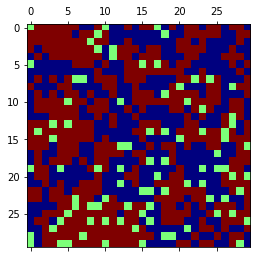

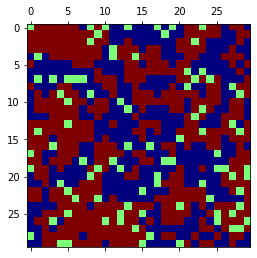

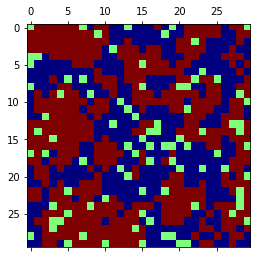

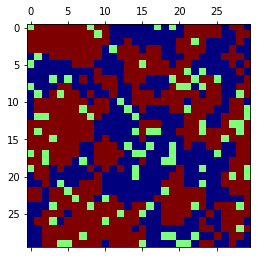

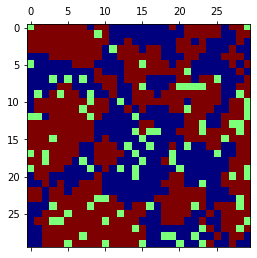

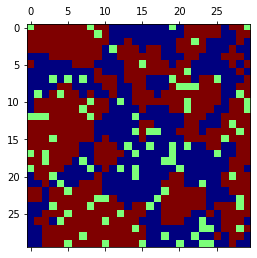

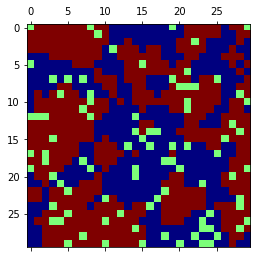

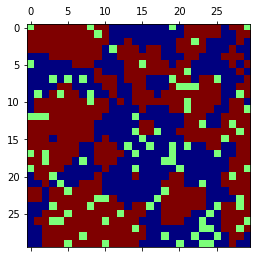

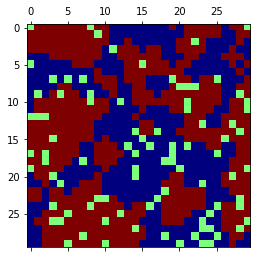

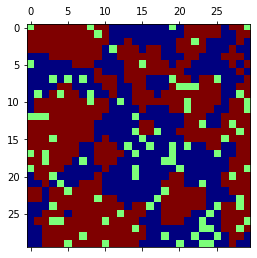

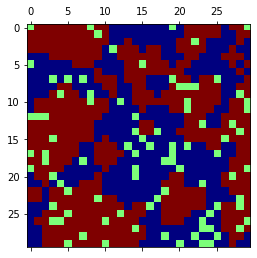

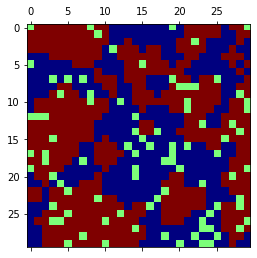

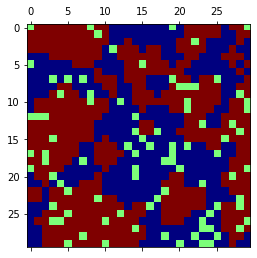

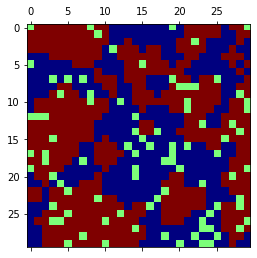

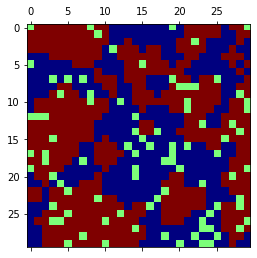

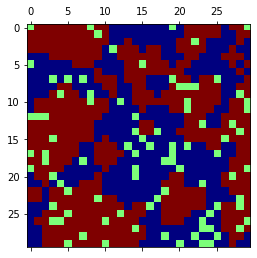

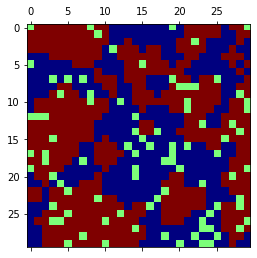

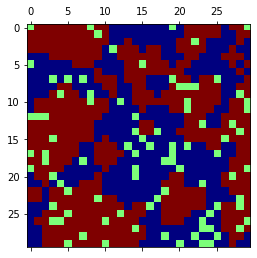

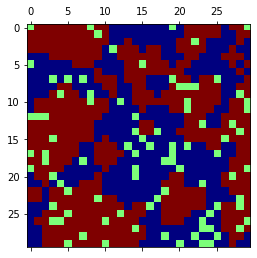

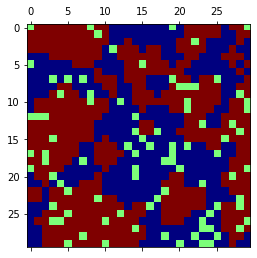

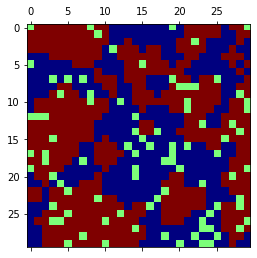

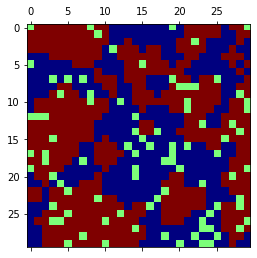

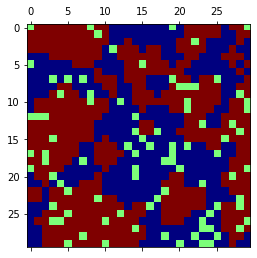

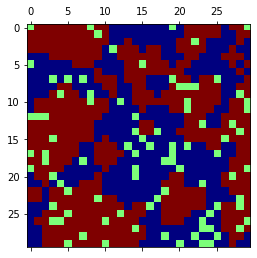

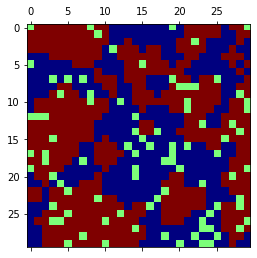

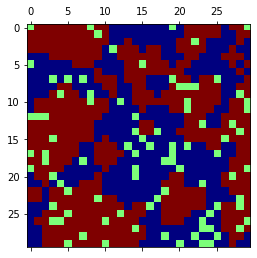

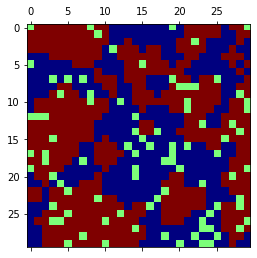

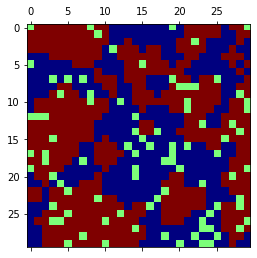

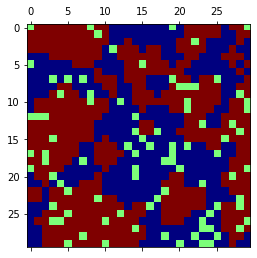

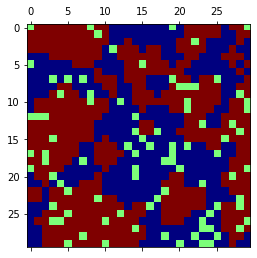

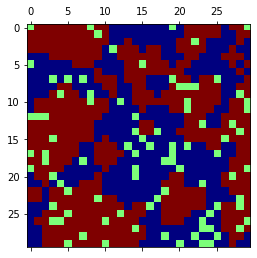

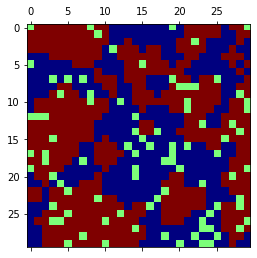

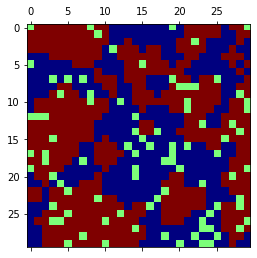

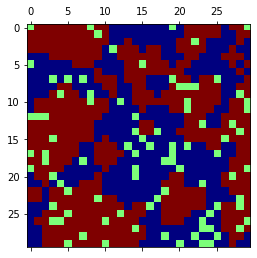

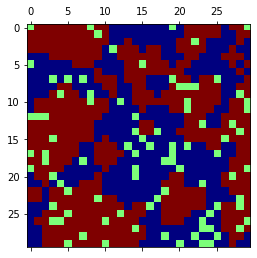

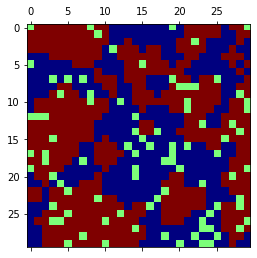

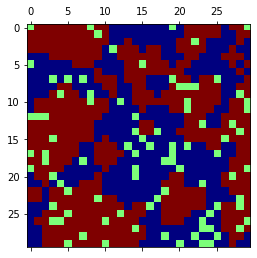

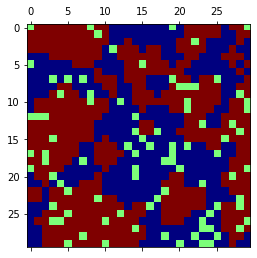

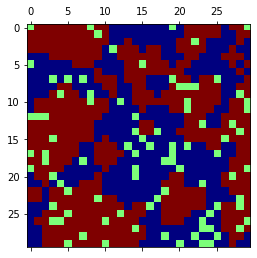

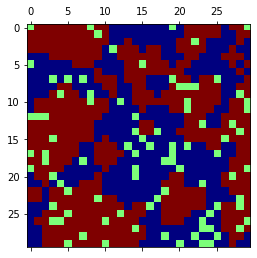

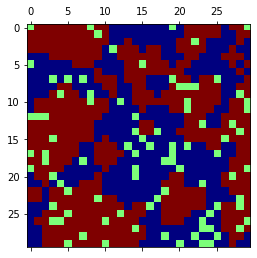

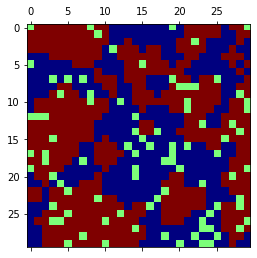

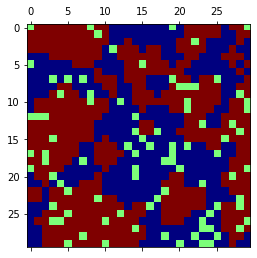

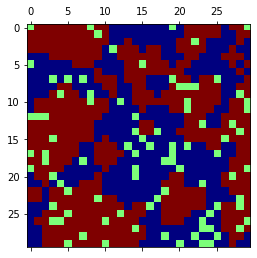

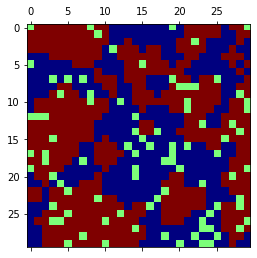

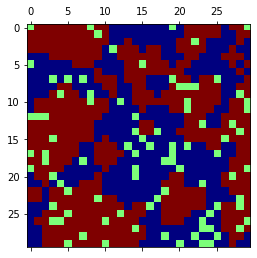

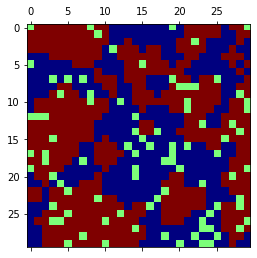

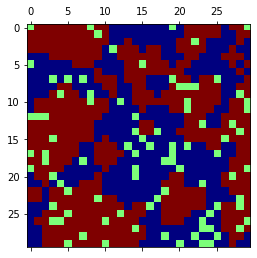

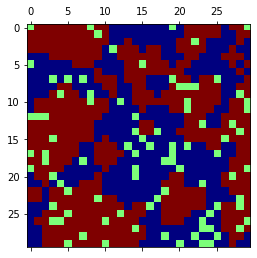

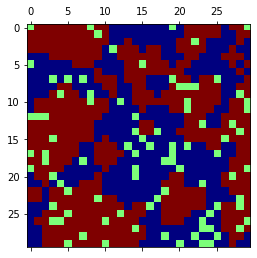

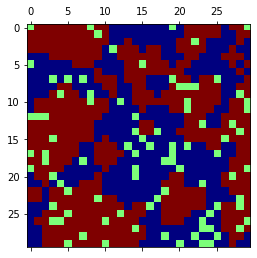

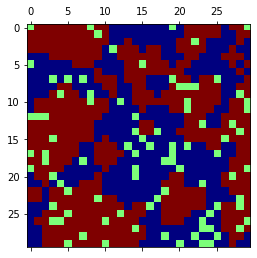

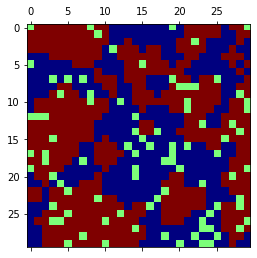

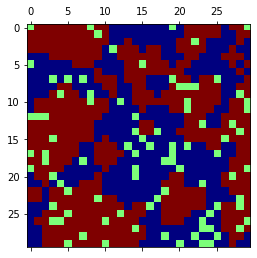

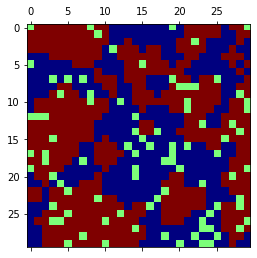

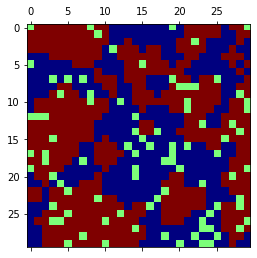

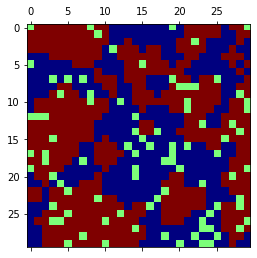

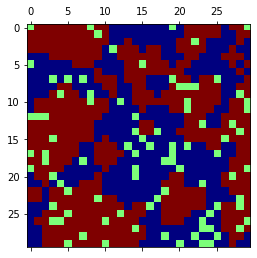

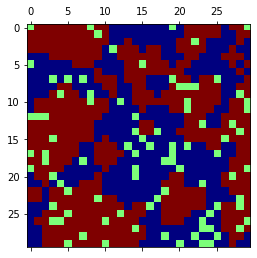

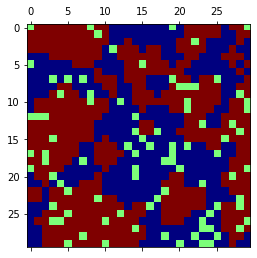

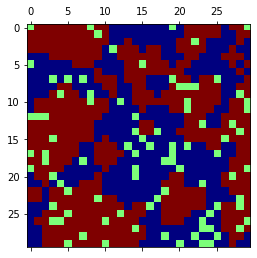

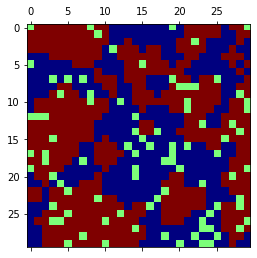

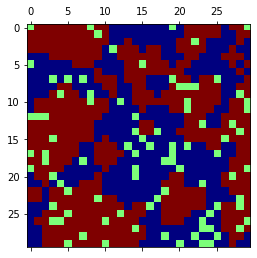

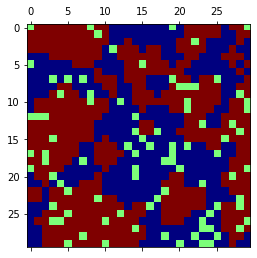

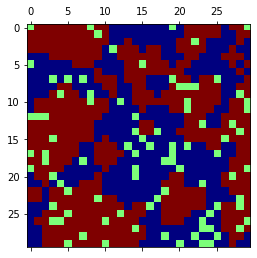

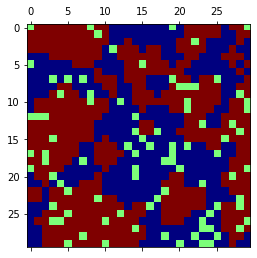

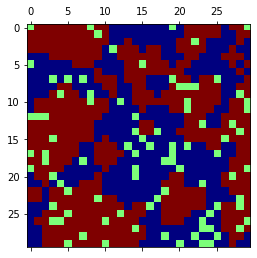

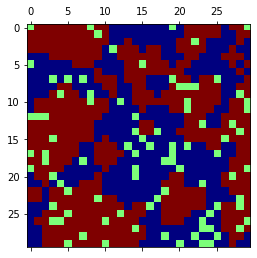

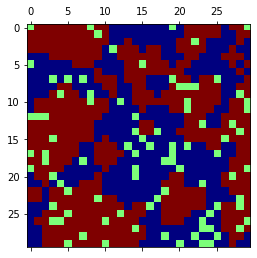

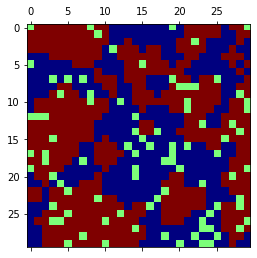

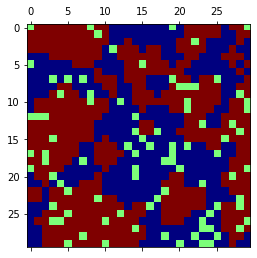

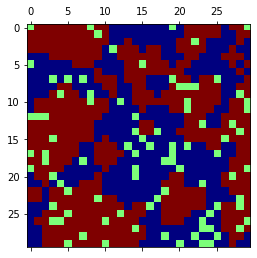

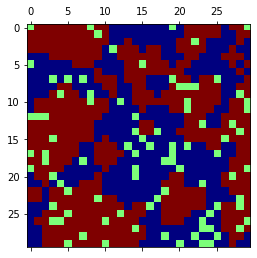

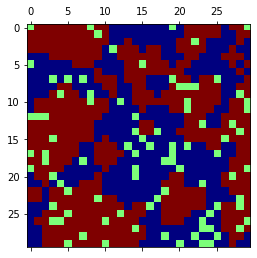

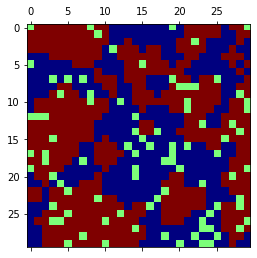

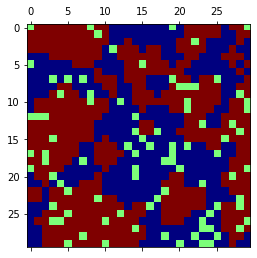

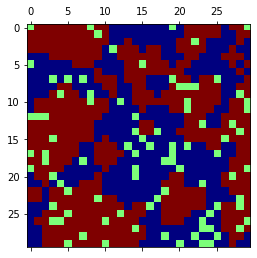

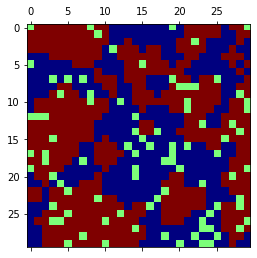

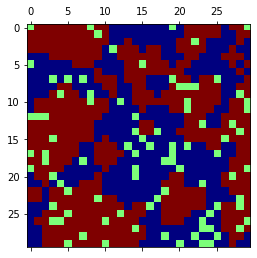

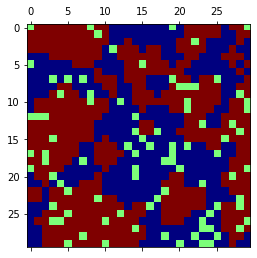

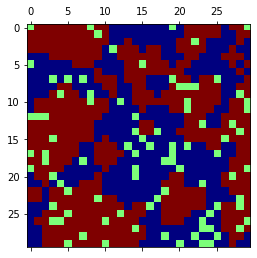

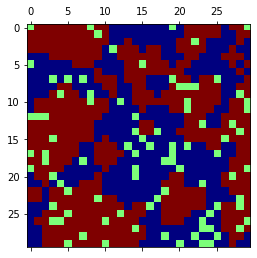

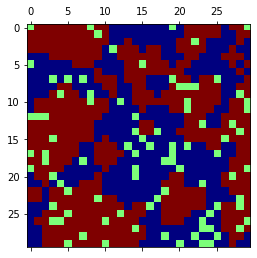

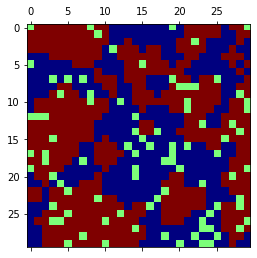

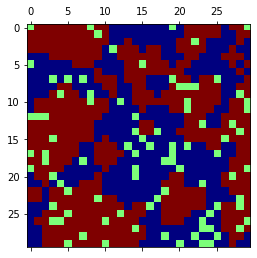

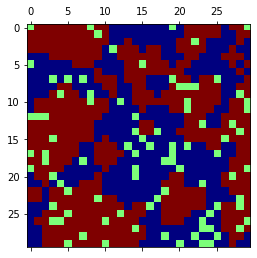

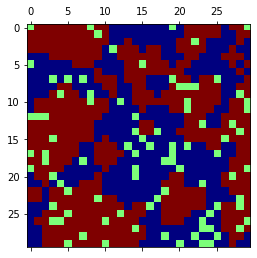

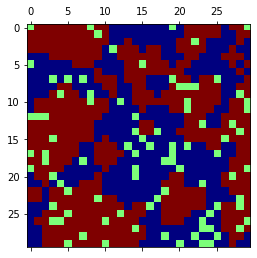

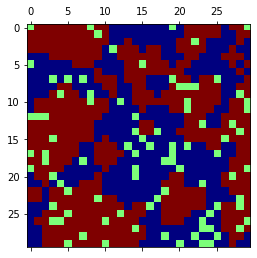

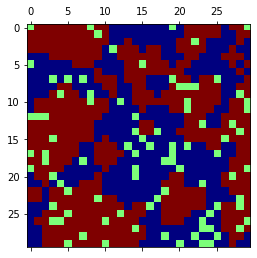

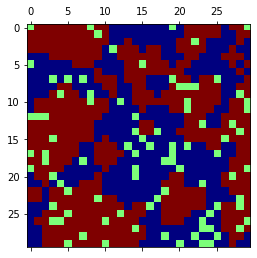

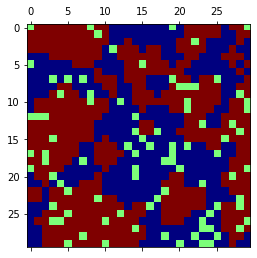

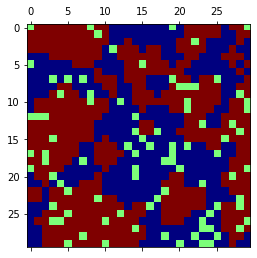

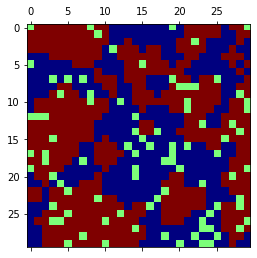

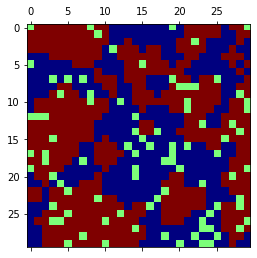

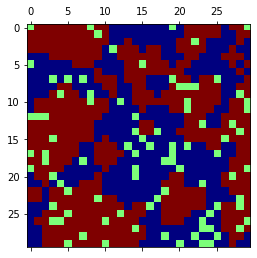

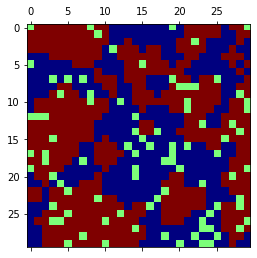

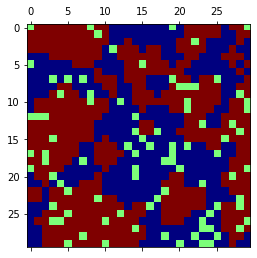

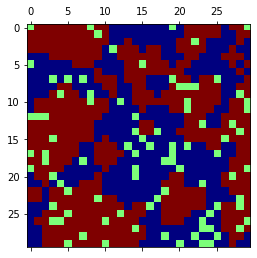

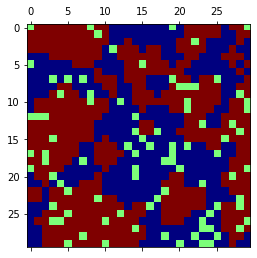

In [24]:
import matplotlib.pyplot as plt
final_list = make_list(100, (30,30), 0.5, 0.1, 0.3)

for arr in final_list:
    plt.matshow(arr,cmap='jet')
    plt.show()
